## 0. Introduction

The aim of this lab is to get familiar with **Mixture of Gaussians** model.


1.   This lab is the course-work activity **Assignment 2: Unsupervised Learning(20%)**
2. The Assignment is due on **Friday , 1st December, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).

In [1]:
import os
import numpy as np
import scipy
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

For this lab, we will use the Peterson and Barney’s dataset of vowel formant frequencies. (For more info, look at Classification of Peterson & Barney’s vowels using Weka - a copy of this article is on QMplus)

More specifically, Peterson and Barney measured the fundamental frequency $F0$ and the first three formant frequencies ($F_1-F_3$) of sustained English Vowels, using samples from various speakers.

Upload the `.npy` file and load it using the code block below.

In [2]:
from google.colab import files
files.upload()
data_npy_file = 'PB_data.npy'

# Loading data from .npy file
data = np.load(data_npy_file, allow_pickle=True)

Saving PB_data.npy to PB_data (1).npy


In [3]:
data

array({'f3': array([2850, 2790, 2640, ..., 3380, 2160, 2200], dtype=uint16), 'f2': array([2280, 2400, 2030, ..., 1140, 1850, 1830], dtype=uint16), 'f1': array([240, 280, 390, ..., 500, 740, 660], dtype=uint16), 'f0': array([160, 186, 203, ..., 334, 308, 328], dtype=uint16), 'phoneme_id': array([ 1,  1,  2, ...,  9, 10, 10], dtype=uint8)},
      dtype=object)

The dataset contains 4 vectors ($F_0-F_3$), containing the fundamental frequencies ($F_0$, $F_1$, $F_2$ and $F_3$) for each phoneme and another vector `phoneme_id` containing a number representing the id of the phoneme. In the exercises that follow, we will use only the dataset associated with formants $F_1$ and $F_2$.<br><br>
**NOTE**: Phonemes and frequencies are two different things; `phoneme_id` is the ground truth class of each row while frequencies represent features of each data point. Please review the papers provided with the lab materials for more details.

In [4]:
data = np.ndarray.tolist(data)
# Array that contains the phoneme ID (1-10) of each sample
phoneme_id = data['phoneme_id']

# frequencies f1 and f2
f1 = data['f1']
f2 = data['f2']

### <font color="maroon"> Q1. Produce a plot of $F1$ against $F2$. (You should be able to spot some clusters already in this scatter plot.). Comment on the figure and the visible clusters [2 marks]</font>

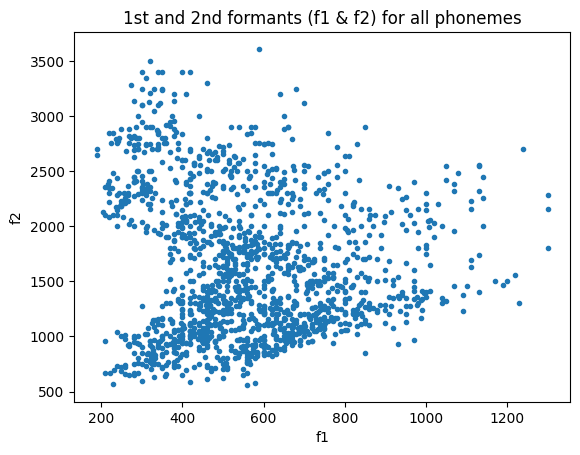

In [5]:
plt.scatter(f1, f2, marker='.')
plt.title("1st and 2nd formants (f1 & f2) for all phonemes")
plt.xlabel("f1")
plt.ylabel("f2")
plt.show()

**OBSERVATIONS**:

The above figure shows the scatterplot of observations, wherein one feature (dimension) is the 1st formant while the other feature is the 2nd formant. Together, the 1st and 2nd formants observed form a single point, and each such point belongs to either the _phoneme 1_ class or _phoneme 2_ class. The classes are not distinguished above, but we can make out some rough non-linear lines of division in the collection of points above, forming roughly two broad clusters, potentially corresponding the the respective classes the points belong to.

# 1. MoG using the EM algorithm

Recall the following definition of a Mixture of Gaussians. Assuming our observed random vector is $\mathbf{x}\in\mathbb{R}^D$, a MoG models $p(\mathbf{x})$ as a sum of $K$-many weighted Gaussians. More specifically:


\begin{equation}
 p(\mathbf{x}) = \sum_{k=1}^K p(c_k) Norm(\mathbf{x} | \mu_k, \Sigma_k) =  \sum_{k=1}^K \frac{p(c_{k})}{(2\pi)^{D/2} \mathrm{det}\left(\boldsymbol\Sigma_k\right)^{1/2}}
 % \exp(-\frac{1}{2}(x-\mu)^T \sum_{k}^{-1}(x-\mu))
 \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_k)^\top {\boldsymbol\Sigma_k}^{-1}(\mathbf{x}-\boldsymbol\mu_k)\right)
\end{equation}
where:
* $\boldsymbol\mu_k\in\mathbb{R}^{D}$
* $\boldsymbol\Sigma_{k}\in\mathbb{R}^{D\times D}$
* $p(c_{k})=\pi_k\in\mathbb{R}$

denote the $k$-th gaussian component's **mean vector**, **covariance matrix**, and **mixture coefficients** respectively. The $K$-many gaussian components' model parameters are referred to collectively as: $\theta = \{\boldsymbol\mu_k,\boldsymbol\Sigma_{k},\pi_k\}_{k=1}^K$

## EM Algorithm
For the E step we softly assign each datum to the closest centroid (using the current iteration's fixed model parameters) as in the K means example.

For the M step we update the model parameters $\theta$ to maximize the weighted log-likelihood.
At a high level, for each centroid k we:
* Update the mean vectors
* Update the covariance matrices (We will fit Gaussians with diagonal covariance matrices)
* Set the mixture coefficients ($p(c_1), p(c_2),$ etc.) as the mean probability of a sample being generated by the k-th gaussian component

Read the code below and understand what it is calculating

In [6]:
def get_predictions(mu, s, p, X):
	"""
	param mu	: means of GMM components
	param s		: covariances of GMM components
	param p 	: weights of GMM components
	param X		: 2D array of our dataset
	"""

	# Get number of GMM components:
	# GMM ==> Gaussian Mixture Model
	k = s.shape[0]
	# Get number of data samples:
	N = X.shape[0]
	# Get dimensionality of our dataset:
	D = X.shape[1]

	Z = np.zeros((N, k))
	for i in range(k):
		mu_i = mu[i, :]
		mu_i = np.expand_dims(mu_i, axis=1)
		mu_i_repeated = np.repeat(mu_i, N, axis=1)
		X_minus_mu = X - mu_i_repeated.transpose()
		inverse_s = scipy.linalg.pinv(s[i])
		inverse_s = np.squeeze(inverse_s)
		s_i_det = scipy.linalg.det(s[i])
		x_s_x = np.matmul(X_minus_mu, inverse_s)*X_minus_mu
		try:
			a = ((2*np.pi)**D) * np.abs(s_i_det)
			if a == 0: continue
			Z[:, i] = p[i]*(1/np.power(a, 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))
		except: pass
	return Z

### Helper functions

In [7]:
def plot_gaussians(ax, s, mu, X, title_string, plot_points=True):
  """
  param ax   : Existing subplot (we must draw on it)
  param s    : Array of covariance matrices per distribution
  param mu   : Array of mean pairs per distribution
  param X    : 2D array of our dataset
  """
  # Plot the data points:
  if plot_points:
    ax.clear()
    if X.shape[1] == 2:
        # Set label of horizontal axis
        ax.set_xlabel('f1')
        # Set label of vertical axis
        ax.set_ylabel('f2')
        # Scatter the points, with red color
        ax.scatter(X[:,0], X[:,1], c='black', marker='.', label=title_string)
    elif X.shape[1] == 3:
      plot_data_3D(X, title_string, ax)

  k = s.shape[0]
  color_list = ['r', 'g', 'b', 'c', 'm', 'y']
  N_sides = 36
  # N_sides-1: The number of sides for the contour polygon
  # NOTE 1: The contour is an elipse, but we approximate this using a polygon
  # NOTE 2: '-1' is due to the way Python ranges work (relevant for code below)

  # Iterate over all gaussians
  for k_cnt in range(k):

      # Pick the covariance matrix and mean values of each gaussian
      s_k = s[k_cnt]
      mu_k = mu[k_cnt]

      if s_k.shape[0]==2:
          # Dataset with 2 features
          side_range = np.arange(0, N_sides, 1)
          theta = 2*np.pi*side_range/(N_sides-1)
          matrix = np.array([np.cos(theta), np.sin(theta)])
          mu_k = np.expand_dims(mu_k, axis=1)
          mu_repeated = np.repeat(mu_k, N_sides, axis=1)
          epoints = np.matmul(scipy.linalg.sqrtm(s_k), matrix) + mu_repeated
          """
          NOTE ON THE ABOVE 6 LINES OF CODE:

          Check "IMPLEMENTATION NOTE 1" in the text below this code
          """
          plt.plot(epoints[0,:], epoints[1,:], color=color_list[k_cnt], linewidth=2)
          plt.scatter(mu_k[0], mu_k[1], color=color_list[k_cnt], marker='o', linewidth=2)
      elif s_k.shape[0]==3:
          # Dataset with 3 features
          side_range = np.arange(0, N_sides, 1)
          theta = np.pi*side_range/(N_sides-1)
          phi = 2*np.pi*side_range/(N_sides-1)
          sin_theta = np.expand_dims(np.sin(theta), axis=1)
          cos_theta = np.expand_dims(np.cos(theta), axis=1)
          sin_phi = np.expand_dims(np.sin(phi), axis=1)
          cos_phi = np.expand_dims(np.cos(phi), axis=1)
          sx = np.matmul(sin_theta, cos_phi.transpose())
          sy = np.matmul(sin_theta, sin_phi.transpose())
          sz = np.matmul(cos_theta, np.ones((1, N_sides)))
          svect = np.array([sx.reshape((N_sides*N_sides)),
                            sy.reshape((N_sides*N_sides)),
                            sz.reshape((N_sides*N_sides))])

          mu_k = np.expand_dims(mu_k, axis=1)
          mu_repeated = np.repeat(mu_k, N_sides*N_sides, axis=1)
          epoints = np.matmul(scipy.linalg.sqrtm(s_k), svect) + mu_repeated

          ex = epoints[0]
          ey = epoints[1]
          ez = epoints[2]

          ax.plot3D(epoints[0,:], epoints[1,:], epoints[2,:], color=color_list[k_cnt])
          ax.plot3D(ex, ey, ez, color=color_list[k_cnt])
      else:
          print('Each dataset sample should have either 2 or 3 features!')
  ax.legend()
  display.clear_output(wait=True)
  plt.show()

**NOTES ON FUNCTION** `plot_gaussian` **AS IMPLEMENTED ABOVE**<br><br>
**IMPLEMENTATION NOTE 1**:<br>_This note is on the 6 lines of code referred to in the comments of the function above_.<br><br>Note that each iteration of this loop focuses on one multivariate Gaussian distribution with mean `mu_k` and covariance matrix `s_k`. Each Gaussian distribution is a distribution over two features F1 and F2.          

---

1) <u>Creating the cluster-boundary polygon template</u>

$2\pi$ is the number of radians for a full circle. `theta` contains the angles (in radians) that together trace a regular polygon with `N_sides` $-1$ sides. For example, if `N_sides` $-1$ equals $6$, then `theta` contains the angles:

$\pi/3, 2\pi/3, \pi, 4\pi/3, 5\pi/3, 2\pi$

Hence, for each element i of `theta`:

- $\cos($ `theta` $[i])$ = $x$-coordinate of the $i$th vertex of $P$
- $\sin($ `theta` $[i])$ = $y$-coordinate of the $i$th vertex of $P$

where $P$ is the (`N_sides` $-1$) sided polygon with centre being $(0, 0)$ (origin) and with the distance between each vertex and the centre being $1$. Note that when we say ith vertex, we mean ith vertex starting from `theta` $[i] = 0$ and moving anti-clockwise.

Hence, `matrix` is a $2 \times $ (`N_sides` $-1)$ matrix where the ith column is
the coordinate for the ith vertex of the aforementioned polygon $P$.

---

2) <u>Transforming the cluster-boundary polygon</u>

- `s_k`:<br>The covariance matrix, with dimensionality $2 \times 2$. The element $[i, j]$ is the covariance between features indexed as $i$ and $j$. In particular, each element of the diagonal $[i, i]$ is the variance of the feature indexed as $i$.
- `mu_k`:<br>The mean vector of the distribution, a vector of two values (one corresponding to each feature). `mu_repeated` is a $2 \times $ (`N_sides` $-1)$ matrix wherein each column vector is `mu_k`.

The cluster-boundary polygon is transformed in two steps:

1. Scaling each vertex $i$ by the square root of the respective covariance matrix, wherein the $x$-coordinate is scaled by row $1$ and the $y$-coordinate is scaled by row $2$; hence, the resultant matrix is a $2 \times $ (`N_sides` $-1)$ matrix wherein each column contains the coordinates for the new vertex
2. Translating each vertex by the respective means; each coordinate is added by that feature's mean, thus translating each vertex

The matrix `epoints` contains the above transformation's results. The row $1$ contains all the new $x$-coordinates while the row $2$ contains all the new $y$-coordinates. Together, they trace the cluster-boundary polygon P which roughly captures the cluster of points indicated by the given multivariate Gaussian distribution.

---

3) <u>What does the cluster-boundary polygon show?</u>

The cluster-boundary polygon roughly represents the area of points within a certain boundary (as scaled by the square root of the covariance matrix) from the centre (mean) of the given mutlivariate Gaussian distribution.

Clustering in this case are not as much based on hard-boundary groups (hard clustering) and as they are based on probabilitistic spectrums (soft clustering) where each observation (a vector of multiple feature values) belongs to the $k$ available multivariate Gaussian distribution with some probability density assigned to it; the higher the density a distribution gives it, the more strongly it is part of the cluster represented by the distribution.

We can think of the distributions as multiple 3D mountains being projected (from top-down) on a 2D plane as contours covering a set of points with varying bands of probability densities.

In [8]:
def plot_data_3D(X, title_string, ax):
  """
    param X    : 2D array of our dataset
    param y    : 1D array of the groundtruth labels of the dataset
    param ax   : existing subplot, to draw on it
  """
  # Clear subplot from previous (if any) drawn stuff
  ax.clear()
  # Set label of x axis
  ax.set_xlabel('f1')
  # Set label of y axis
  ax.set_ylabel('f2')
  # Set label of z axis
  ax.set_zlabel('f1 + f2')
  # Scatter the points, with red color
  ax.scatter3D(X[:,0], X[:,1], X[:,2], c='black', marker='.', label=title_string)
  # Add legend to the subplot
  ax.legend()

def save_model(mu, s, p, k, p_id):
  GMM_parameters = {}
  GMM_parameters['mu'] = mu
  GMM_parameters['s'] = s
  GMM_parameters['p'] = p
  if not os.path.isdir('data/'):
    os.mkdir('data/')
  npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
  np.save(npy_filename, GMM_parameters)

## Train MoG

Read the following blocks of code and understand what it does.

In [9]:
X_full = np.zeros((len(f1), 2))
X_full[:,0] = f1.copy()
X_full[:,1] = f2.copy()
X_full = X_full.astype(np.float32)

In [10]:
def train_MoG(X_full, k, p_id, n_iter=100):
  """
  X_full : The full dataset
  k      : The number of distributions to optimise
  p_id   : The phoneme ID with respect to which the data must be used
  n_iter : Number of iterations for the EM algorithm
  """
  # INITIALISATION

  # The required subset of X_full:
  X = X_full[phoneme_id==p_id,:]
  # NOTE: This is the data to be used for the training
  """
  ABOUT THE DATA USED:
  We are using the data on the formants 1 and 2 (F1 and F2 respectively) which
  correspond to the phoneme with ID given as `p_id` and clustering the data
  accordingly.
  """
  #================================================
  # TRAINING

  # Get number of samples:
  N = X.shape[0]
  # Get dimensionality of our dataset:
  D = X.shape[1]
  # Common practice: GMM weights initially set as 1/k:
  p = np.ones((k))/k
  # GMM means are picked randomly from data samples:
  random_indices = np.floor(N*np.random.rand((k)))
  random_indices = random_indices.astype(int)
  mu = X[random_indices,:] # shape kxD
  # Covariance matrices:
  s = np.zeros((k,D,D)) # shape kxDxD

  # Initialize covariances
  for i in range(k):
      cov_matrix = np.cov(X.transpose())
      # Initially set to fraction of data covariance
      s[i,:,:] = cov_matrix/k

  # Initialize array Z that will get the predictions of each Gaussian on each sample
  Z = np.zeros((N,k)) # shape Nxk

  ###################################################
  # Run EM (Expectation-Maximization) algorithm for n_iter iterations:
  for t in range(n_iter):
      print('Iteration {:03}/{:03}'.format(t+1, n_iter))

      # Do the E-step
      Z = get_predictions(mu, s, p, X)
      Z = normalize(Z, axis=1, norm='l1')

      # Do the M-step:
      for i in range(k):
          a = np.sum(Z[:,i])
          if a == 0: continue
          mu[i,:] = np.matmul(X.transpose(),Z[:,i]) / a

          ###################################################
          # We will fit Gaussians with diagonal covariance matrices:
          mu_i = mu[i,:]
          mu_i = np.expand_dims(mu_i, axis=1)
          mu_i_repeated = np.repeat(mu_i, N, axis=1)
          coef_1 = (X.transpose() - mu_i_repeated)**2
          coef_2 = Z[:,i]/np.sum(Z[:,i])
          coef_2 = np.expand_dims(coef_2, axis=1)
          res_1 = np.squeeze(np.matmul(coef_1, coef_2))
          s[i,:,:] = np.diag(res_1) # Reassigns the i-th covariance matrix

          p[i] = np.mean(Z[:,i])

      fig, ax1 = plt.subplots()
      plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
  print('\nFinished.\n')
  print(f"Optimised a mixture of {k} mutlivariate Gaussian distributions.")
  print("------------------------")
  print(f"Array of {k} mean pairs:\n{mu}")
  print("------------------------")
  print(f"Array of {k} covariance matrices:\n{s}")
  save_model(mu, s, p, k, p_id)

### <font color="maroon"> Q2. Run the code multiple times for $K=3$, what do you observe? Use figures and the printed MoG parameters to support your arguments [2 mark] </font>

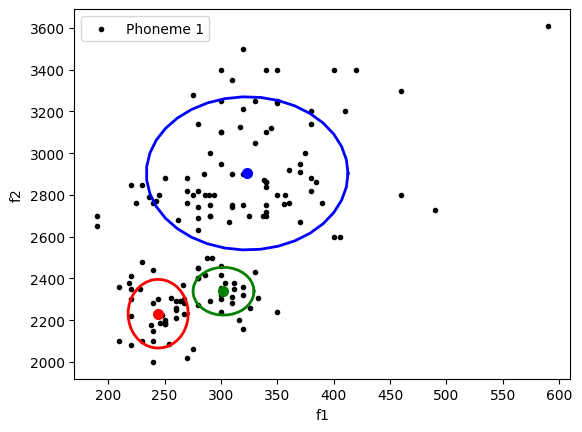


Finished.

Optimised a mixture of 3 mutlivariate Gaussian distributions.
------------------------
Array of 3 mean pairs:
[[ 244.30173 2231.018  ]
 [ 302.26318 2338.8552 ]
 [ 323.24017 2903.5635 ]]
------------------------
Array of 3 covariance matrices:
[[[  356.12435852     0.        ]
  [    0.         13577.91929416]]

 [[  365.77104812     0.        ]
  [    0.          6568.98447513]]

 [[ 4002.5369457      0.        ]
  [    0.         67340.67891838]]]


In [11]:
train_MoG(X_full, k=3, p_id=1, n_iter=100)

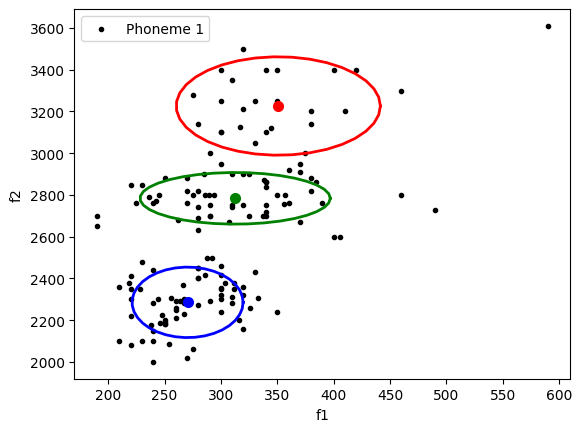


Finished.

Optimised a mixture of 3 mutlivariate Gaussian distributions.
------------------------
Array of 3 mean pairs:
[[ 350.8446  3226.3394 ]
 [ 312.59125 2783.898  ]
 [ 270.3952  2285.4653 ]]
------------------------
Array of 3 covariance matrices:
[[[ 4102.875375       0.        ]
  [    0.         27829.54221422]]

 [[ 3562.59743765     0.        ]
  [    0.          7657.84897245]]

 [[ 1213.73843494     0.        ]
  [    0.         14278.4202995 ]]]


In [12]:
train_MoG(X_full, k=3, p_id=1, n_iter=100)

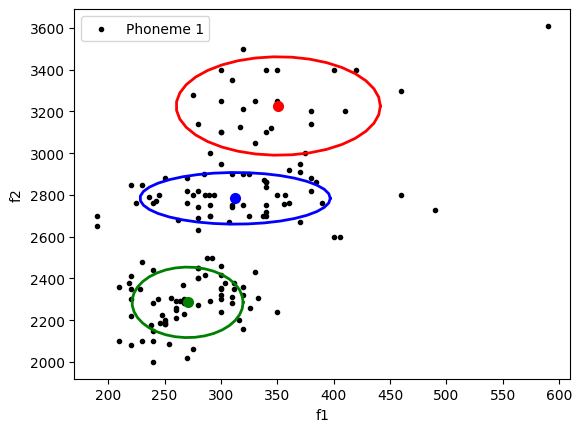


Finished.

Optimised a mixture of 3 mutlivariate Gaussian distributions.
------------------------
Array of 3 mean pairs:
[[ 350.8446  3226.3389 ]
 [ 270.3952  2285.4653 ]
 [ 312.59122 2783.8977 ]]
------------------------
Array of 3 covariance matrices:
[[[ 4102.87219782     0.        ]
  [    0.         27829.68964299]]

 [[ 1213.73843072     0.        ]
  [    0.         14278.41963527]]

 [[ 3562.59793761     0.        ]
  [    0.          7657.83360043]]]


In [13]:
train_MoG(X_full, k=3, p_id=1, n_iter=100)

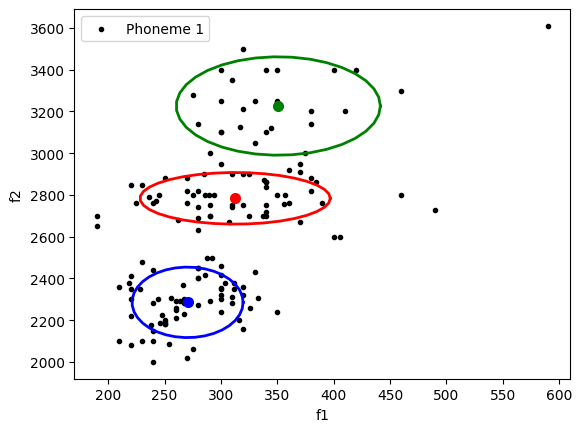


Finished.

Optimised a mixture of 3 mutlivariate Gaussian distributions.
------------------------
Array of 3 mean pairs:
[[ 312.59125 2783.898  ]
 [ 350.8446  3226.3394 ]
 [ 270.3952  2285.4653 ]]
------------------------
Array of 3 covariance matrices:
[[[ 3562.59743765     0.        ]
  [    0.          7657.84897245]]

 [[ 4102.875375       0.        ]
  [    0.         27829.54221422]]

 [[ 1213.73843494     0.        ]
  [    0.         14278.4202995 ]]]


In [14]:
train_MoG(X_full, k=3, p_id=1, n_iter=100)

**OBSERVATIONS**:

The cluster-boundary polygon roughly represents the area of points within a certain boundary (as scaled by the square root of the covariance matrix) from the centre (mean) of the given mutlivariate Gaussian distribution. Clustering in this case are not as much based on hard-boundary groups (hard clustering) and as they are based on probabilitistic spectrums (soft clustering) where each observation (a vector of multiple feature values) belongs to the $k$ available multivariate Gaussian distribution with some probability density assigned to it; the higher the density a distribution gives it, the more strongly it is part of the cluster represented by the distribution.

In the above graphs, we see a better-than-random clustering of the points with respect to the cluster-boundary polygons. This indicates that the separation of the points with respect to their clusters within a single class (_phoneme 1_ in this case) has been obtained, indicating that the mixture of Gaussians adequately models the probability densities of the observations (probability density is with respect to a point belonging to the given class). The cluster-boundary polygons also help identify the outliers, i.e. the points that do belong to the given class, but would generally by regarded as outside the given class if observed separately.

From the covariance matrices obtained for the above mixture of Gaussians, we observe that there is zero covariance between the features $F_1$ and $F_2$ (i.e. the 1st and 2nd formants). This is based on the assumption of zero covariance, and is achieved by the lines:

```python
coef_2 = Z[:,i]/np.sum(Z[:,i])
coef_2 = np.expand_dims(coef_2, axis=1)
res_1 = np.squeeze(np.matmul(coef_1, coef_2))
s[i,:,:] = np.diag(res_1)
```

Hence, the training process assumes that covariance is zero, leaving only the diagonal of the covariance matrix (which contains the variance values) non-zero.

###  Q3. Repeat the training for phoneme_id = 2  and save the parameters [1 mark]
### Q4. Repeat training for $K=6$ for phoneme_id =1 and phoneme_id=2 and save the model parameters [1 mark]

Save your MoG model: this should comprise the variables mu, s and p. Include the all the saved model parameters in the submission .zip folder.

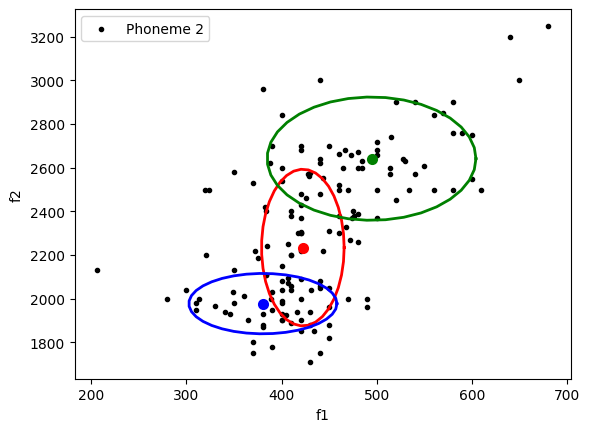


Finished.

Optimised a mixture of 3 mutlivariate Gaussian distributions.
------------------------
Array of 3 mean pairs:
[[ 422.3022  2234.1277 ]
 [ 494.51273 2641.6702 ]
 [ 380.30887 1977.2128 ]]
------------------------
Array of 3 covariance matrices:
[[[  943.06000798     0.        ]
  [    0.         64496.74228989]]

 [[ 6026.15481398     0.        ]
  [    0.         39915.7981507 ]]

 [[ 3030.77043069     0.        ]
  [    0.          9576.95281344]]]


In [16]:
train_MoG(X_full, k=3, p_id=2, n_iter=100)

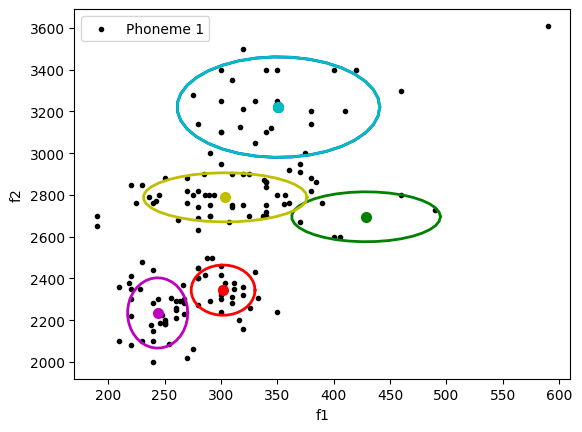


Finished.

Optimised a mixture of 6 mutlivariate Gaussian distributions.
------------------------
Array of 6 mean pairs:
[[ 301.88284 2343.9585 ]
 [ 428.68753 2695.5222 ]
 [ 350.95862 3220.9436 ]
 [ 350.95862 3220.9436 ]
 [ 243.85101 2234.6062 ]
 [ 303.77734 2788.561  ]]
------------------------
Array of 6 covariance matrices:
[[[  401.32946488     0.        ]
  [    0.          7251.52945585]]

 [[ 2176.17421795     0.        ]
  [    0.          7159.14866994]]

 [[ 4039.42702966     0.        ]
  [    0.         29007.86518656]]

 [[ 4039.42702966     0.        ]
  [    0.         29007.86518656]]

 [[  356.29760445     0.        ]
  [    0.         14200.71682884]]

 [[ 2634.46562124     0.        ]
  [    0.          6930.41078046]]]


In [17]:
train_MoG(X_full, k=6, p_id=1, n_iter=100)

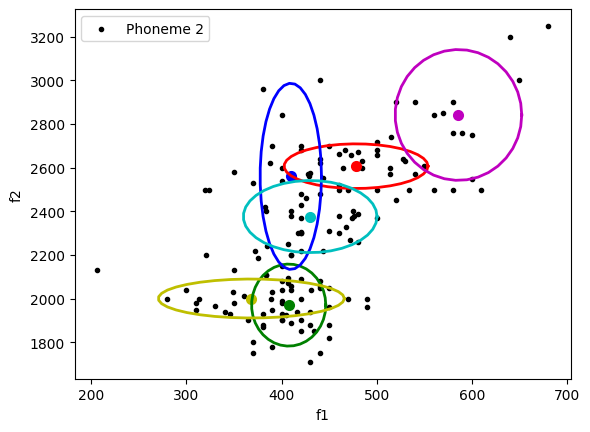


Finished.

Optimised a mixture of 6 mutlivariate Gaussian distributions.
------------------------
Array of 6 mean pairs:
[[ 478.23367 2607.1816 ]
 [ 407.41867 1970.4957 ]
 [ 409.6318  2560.504  ]
 [ 430.02243 2376.2349 ]
 [ 585.8643  2842.0146 ]
 [ 368.13968 2000.6796 ]]
------------------------
Array of 6 covariance matrices:
[[[ 2861.07670765     0.        ]
  [    0.          5238.66758414]]

 [[  760.59118817     0.        ]
  [    0.         17679.11180198]]

 [[  520.38500458     0.        ]
  [    0.         91066.08328077]]

 [[ 2470.12879111     0.        ]
  [    0.         13656.25587789]]

 [[ 2214.89533439     0.        ]
  [    0.         44976.93798369]]

 [[ 4781.99112685     0.        ]
  [    0.          3988.63168794]]]


In [18]:
train_MoG(X_full, k=6, p_id=2, n_iter=100)

### <font color="maroon"> Q5. Use the 2 MoGs ($K=3$) learnt in tasks 2 & 3 to build a classifier to discriminate between phonemes 1 and 2, and explain the process in the report [4 marks] </font>

Classify using the Maximum Likelihood (ML) criterion and calculate the misclassification error. Remember that a classification under the ML compares $p(\mathbf{x};\boldsymbol\theta_{1})$, where $\boldsymbol\theta_{1}$ are the parameters of the MoG learnt for the first phoneme, with $p(\mathbf{x};\boldsymbol\theta_{2})$, where $\boldsymbol\theta_{2}$  are the parameters of the MoG learnt for the second phoneme.

In [19]:
inds_1 = np.where(phoneme_id==1)
inds_2 = np.where(phoneme_id==2)
inds_1 = inds_1[0]
inds_2 = inds_2[0]
inds_1_and_2 = np.concatenate((inds_1, inds_2), axis=0)
# NOTE: inds_1_and_2 is a 1D array containing all elements of inds_1 & inds_2

X = X_full[inds_1_and_2, :]
Y = phoneme_id[inds_1_and_2]
# Check "IMPLEMENTATION DETAILS" in the text block below this code block

**IMPLEMENTATION DETAILS**
<br><br>
**IMPLEMENTATION NOTE 1**: **The target value array** `phoneme_id`<br>`phoneme_id` is a 1D array of $1520$ values, wherein the same following sequence of $20$ numbers is repeated $76$ times: $1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10$

`phoneme_id` is the vector of target variable values corresponding to each observation. In this particular case, the feature values (valules of formants 1 and 2) were observed with respect to each phoneme, which is why the target variable values are so ordered.

---

**IMPLEMENTATION NOTE 2**: `np.where(phoneme_id==i)`<br>The function call `np.where(phoneme_id==i)` returns the array of indices of the Boolean-valued array `phoneme_id==i` where the value is `True`; equivalently, it returns the 1D array of indices of `phoneme_id` where the value is `i`. The return value of `np.where` is a tuple of 1D arrays; in this case, this tuple contains only one array (as there is only one array to pick indices from), yet the return value is still a tuple. Hence, to pick out the required array of indices, we index the return value using the index $0$, i.e. we pick our the required arrays by `inds_1[0]` and `inds_2[0]`.

---

**IMPLEMENTATION NOTE 3**: **Indexing the observation & observed target arrays** `X_full` **&** `phoneme_id` **using** `inds_1_and_2`:<br>Remember that `X_full` is the matrix of feature variable values, wherein each row is an observation, which is an array of two values: the values of formants 1 and 2 for the given observation. Also remember that the vector of target values for these observations is `phoneme_id`; this means the number of rows in `X_full` is the same as the number of elements in `phoneme_id`.

We select the rows of `X_full` based on the chosen indices of `phoneme_id` obtained before and stored in `inds_1_and_2`. In effect, seeing that the indices in `inds_1_and_2` are all the indices of `phoneme_id` where the phoneme ID is either $1$ or $2$, `X_full[inds_1_and_2,:]` selects all the observations for which the phoneme ID is $1$ or $2$.

We do the same index selection for `phoneme_id` so that we have target values to which we can compare each observation. This will be relevant when testing the accuracy of our classifier.

In [20]:
def classify(X, p_ids, k, c=1):
  N = X.shape[0]
  D = X.shape[1]

  # Get predictions on both phonemes 1, 2, etc, from a GMM with k components:
  # (first pretrained on phoneme 1, then on phoneme 2, etc.)
  GMM_parameters={}
  likelihoods = []
  for i, p_id in enumerate(p_ids):
    npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
    if os.path.isfile(npy_filename):
        # tmp ==> Temporary variable, used for ease of reference
        tmp = np.load(npy_filename, allow_pickle=True)
        tmp = np.ndarray.tolist(tmp)
        # Storing the parameters of the model:
        GMM_parameters[f"phoneme_{p_id:02}_k_{k:02}"] = tmp
    else:
        raise('File {} does not exist.'.format(npy_filename))
    mu = tmp['mu']
    s = tmp['s']
    p = tmp['p']

    # Append prediction array for phoneme `p_id`:
    likelihoods.append(get_predictions(mu, s, p, X))
    likelihoods[-1] = likelihoods[-1].sum(axis=1)

  """
  NOTE ON OBTAINED `likelihoods`:
  The variable likelihood will contain `len(p_ids)` arrays of likelihoods,
  where the ith array contains the likelihoods for each observation of
  belonging to the ith phoneme.
  """

  # Classify each point using maximum likelihood:
  likelihoods = np.array(likelihoods)
  predictions = likelihoods.argmax(axis=0) + c
  # NOTE: Different identifiers are used for conceptual clarity
  """
  EXPLAINING THE ABOVE:
  For each index i in the range [0, N-1], `likelihoods.argmax(axis=0)` returns:
  - 0, referring to the 1st array in `likelihoods` if the 1st array has the
    maximum value at index i
  - 1, referring to the 2nd array in `likelihoods` if the 2nd array has the
    maximum value at index i
  - etc.

  Hence, for each index i in the range [0, N-1], we get the index of that array
  in `likelihood` whose value at index i is maximum.
  """
  # Returning predictions:
  return predictions

#================================================

def getAccuracy(predictions, groundTruth):
  # Calculate accuracy
  nCorrect = len(np.where(predictions==groundTruth)[0])
  """
  SIDE NOTE: To get number of wrong predictions:
  `nWrong = len(np.where(predictions!=groundTruth)[0])`
  """
  # Returning accuracy:
  return nCorrect/len(predictions)

For each class of points (i.e. observations corresponding to `phoneme_1` and `phoneme_2` respectively), we aim to estimate the density distribution for $K$ different Gaussian distributions that together (as a sum) describe the data's classification. A mixture of Gaussians trained for class $C$ is supposed to be such that the sum of the probability densities of the $K$ different Gaussians for a given observation (i.e. a certain tuple of feature values) is the combined probability density of that the observation must be classified into class $C$.

We have mixture models that model each class of points (i.e. the set of observations corresponding to a certain phoneme), and to perform the classification for a given observation, we must do the following:

- For each model trained on a certain class of points:
  - Obtain the probability densities for each Gaussian in the mixture for each given observation
  - Obtain the weighted sum of the above-obtained probability densities for each observation
- For each observation:
  - Compare the combined densities from each model
  - Classify the observation according to the class (i.e. phoneme) corresponding to the model showing the highest combined density

**NOTE**: _The weights are assigned to each Gaussian within a mixture of Gaussians such that the total weighted sum amounts to_ $1$.

---

Running the above classifier...

In [21]:
# Getting results of k=3:
percentageAccuracy = 100*getAccuracy(classify(X, p_ids=[1, 2], k=3), Y)
print(f"Classifier accuracy: {percentageAccuracy:.3f}%")

Classifier accuracy: 96.382%


### <font color="maroon"> Q6. Repeat for $K=6$ and compare the results in terms of accuracy. [2 mark] </font>


In [22]:
# Getting results for k=6 & updating previous models dictionary:
percentageAccuracy = 100*getAccuracy(classify(X, p_ids=[1, 2], k=6), Y)
print(f"Classifier accuracy: {percentageAccuracy:.3f}%")

Classifier accuracy: 95.395%


**COMPARISON**:

When using a mixture of 6 Gaussians instead of 3, i.e. when $K=6$, the accuracy of classification is very similar to when $K=3$ (with some variation). Over multiple trials, neither $K$ value showed consistently more accuracy compared to the other.

### <font color="maroon"> Q7. Display a "classification matrix" assigning labels to a grid of all combinations of the $F1$ and $F2$ features for the $K=3$ classifiers from above. Next, repeat this step for $K=6$ and compare the two. [3 marks] </font>

In particular,
create a custom uniform grid of points that spans all possible intermediate combinations of $F1$ and $F2$ features, using the features' minimum and maximum values as the limits. (Hint: check documentation for [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) and [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) ). Classify each point in the grid using one of your classifiers. That is, create a classification matrix, $\mathbf{M}$, whose elements are either 0 or 1. $M(i,j)$ is 0 if the point at location $(i,j)$ on the custom grid is classified as belonging to phoneme 1, and is 1 otherwise.

### Hint: building the custom grid:
Assuming our data were the orange points below, the custom grid would look something like the following (evenly spaced points spanning the minimum to maximum values of both features):

![](https://i.imgur.com/khfYx42.png)



In [23]:
# INITIALISATION
# NOTE: This is common for this section
X = X_full[inds_1_and_2,:]
N = X.shape[0]
D = X.shape[1]

min_f1 = int(np.min(X[:,0]))
max_f1 = int(np.max(X[:,0]))
min_f2 = int(np.min(X[:,1]))
max_f2 = int(np.max(X[:,1]))
N_f1 = max_f1 - min_f1
N_f2 = max_f2 - min_f2
print('f1 range: {}-{} | {} points'.format(min_f1, max_f1, N_f1))
print('f2 range: {}-{} | {} points'.format(min_f2, max_f2, N_f2))

grid = np.meshgrid(np.arange(min_f1, max_f1, 1),
                    np.arange(min_f2, max_f2, 1),
                    indexing="ij")
inputArray = np.array((list(zip(grid[0].ravel(), grid[1].ravel()))))

f1 range: 190-680 | 490 points
f2 range: 1710-3610 | 1900 points


Defining the function to wrap the necessary code (so we can conveniently run it for $K=3$ and $K=6)$...

In [24]:
def classificationMatrix(inputArray, k, breakPoint=len(inds_1)):
  """
  NOTE ON `breakPoint`:
  `inputArray` is meant to be arranged such that upto a certain point p, the
  observations belong to one class, and after this point, they belong to the
  other class (totally there are two classes). `breakPoint` is the value of the
  point p. In our case, the first p points are of class `phoneme_1`, after
  which the points are of class `phoneme_2`.
  """

  M = classify(inputArray, p_ids=[1, 2], k=k, c=0).reshape(N_f1, N_f2)
  M = M.transpose()
  """
  INSTRUCTIONS FOR THE ABOVE
  - Create a custom grid of shape N_f1 x N_f2
  - The grid will span all the values of (f1, f2) pairs, between [min_f1, max_f1]
    on f1 axis, and between [min_f2, max_f2] on f2 axis
  - Then, classify each point [i.e., each (f1, f2) pair] of that grid, to either
    phoneme 1, or phoneme 2, using the two trained GMMs
  - Do predictions, using GMM trained on phoneme 1, on custom grid
  - Do predictions, using GMM trained on phoneme 2, on custom grid
  - Compare these predictions, to classify each point of the grid
  - Store these prediction in a 2D numpy array named "M", of shape N_f2 x N_f1
    (the first dimension is f2 so that we keep f2 in the plot's vertical axis)
  - M should contain "0.0" in the points that belong to phoneme 1 and "1.0" in
    the points that belong to phoneme 2
  """

  #================================================

  # VISUALISING PREDICTIONS

  # Create a figure
  fig, ax = plt.subplots()

  # Use aspect='auto' (default is 'equal')...
  # ... to force the plotted image to be square, when dimensions are unequal
  plt.imshow(M, aspect='auto')

  # Set label of x axis
  ax.set_xlabel('f1')
  # Set label of y axis
  ax.set_ylabel('f2')

  # Set limits of axes
  plt.xlim((0, N_f1))
  plt.ylim((0, N_f2))

  # Set range and strings of ticks on axes
  x_range = np.arange(0, N_f1, step=50)
  x_strings = [str(x+min_f1) for x in x_range]
  plt.xticks(x_range, x_strings)
  y_range = np.arange(0, N_f2, step=200)
  y_strings = [str(y+min_f2) for y in y_range]
  plt.yticks(y_range, y_strings)

  # Set title of figure:
  plt.title(f"Predictions on custom grid for k={k}")

  # Add a colorbar:
  plt.colorbar()

  N_samples = int(breakPoint)
  plt.scatter(X[:N_samples, 0] - min_f1, X[:N_samples, 1] - min_f2,
              marker='.', color='red', label='Phoneme 1')
  plt.scatter(X[N_samples:, 0] - min_f1, X[N_samples:, 1] - min_f2,
              marker='.', color='green', label='Phoneme 2')

  # Add legend to the subplot:
  plt.legend()
  plt.show()

Displaying classification matrix for $K=3$...

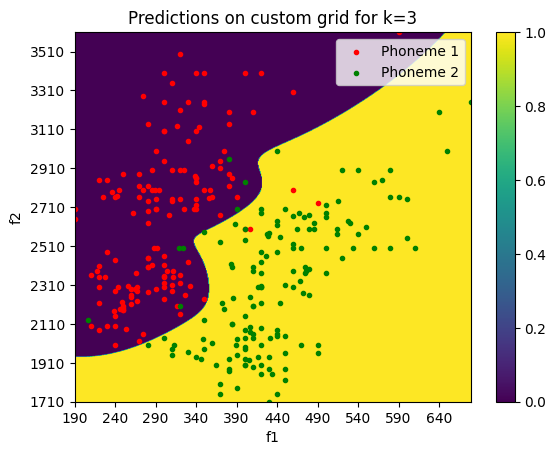

In [25]:
classificationMatrix(inputArray, k=3)

Displaying classification matrix for $K=6$...

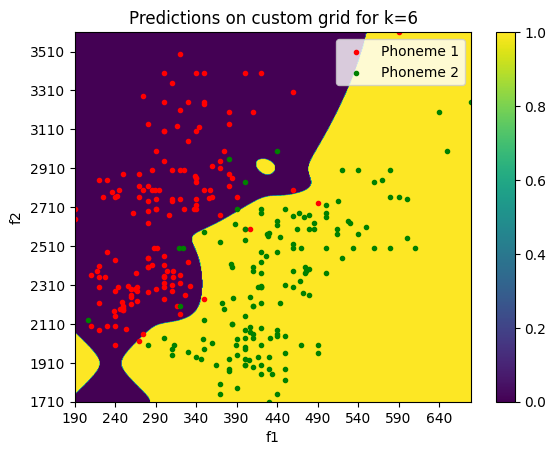

In [26]:
classificationMatrix(inputArray, k=6)

**COMPARISON OF THE ABOVE**:

**NOTE**: _In the above colour scale, 0 means phoneme 1 and 1 means phoneme 2._

While both the above mixtures of Gaussians classify the data points relatively accurately, one notable difference is that when using a mixture of 6 Gaussians instead of 3, i.e. when $K=6$, the classification boundary becomes more complex and more closely fitted to the given data. This means with $K=6$, fewer points are regarded as outliers; this indicates a greater danger to overfitting the mixture of Gaussians model to the given training data.


---

Create a new dataset that will contain 3 columns, as follows:
\begin{equation}
    X = [F_1, F_2, F_1+F_2]
\end{equation}

### <font color="maroon"> Q8. Try to fit a MoG model to the new data. What is the problem that you observe? Explain why it occurs [2 marks]

Creating the data to fit the model to...



In [27]:
p_id = 1 # ID of the phoneme that will be used (ex. 1, or 2)
inds_1 = np.where(phoneme_id==1)

"""
INSTRUCTIONS FOR THE BELOW CODE:
The shape of X is be two-dimensional. Each row will represent a sample of the
dataset, and each column will represent a feature (e.g. f1 or f2 or f1+f2).
Store f1 in the first column of X, f2 in the second column of X and f1+f2 in
the third column of X. Filter X to, contain only samples that belong to the
chosen phoneme.
"""

k = 3 # Number of GMM components
X = np.zeros((len(f1), 3))
X[:, 0] = X_full[:, 0]                # Column 1
X[:, 1] = X_full[:, 1]                # Column 2
X[:, 2] = X_full[:, 0] + X_full[:, 1] # Column 3
X = X[inds_1] # Selecting only those rows corresponding to phoneme 1

Model fitting process...

Iteration 007/150


ValueError: ignored

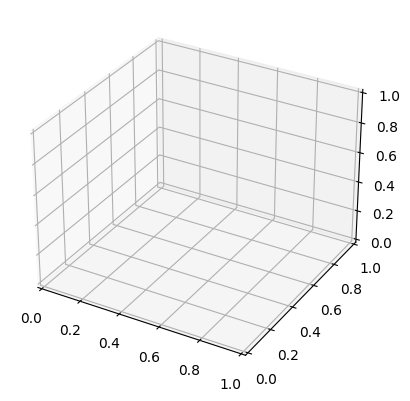

In [28]:
ax = plt.axes(projection='3d')
title_string = 'Phoneme {}'.format(p_id)

N, D = X.shape
p = np.ones((k))/k
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # Shape kxD
s = np.zeros((k,D,D)) # Shape kxDxD
n_iter = 150

# Initialize covariances:
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    s[i,:,:] = cov_matrix/k

Z = np.zeros((N,k)) # shape Nxk

#================================================

# Run Expectation Maximization algorithm for n_iter iterations
zeros = {"t":[], "i":[]}
for t in range(n_iter):
    display.clear_output(wait=True)
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')
    # Do the M-step:
    for i in range(k):
      mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

      #------------------------------------

      # We will fit Gaussians with full covariance matrices:
      mu_i = mu[i,:]
      mu_i = np.expand_dims(mu_i, axis=1)
      mu_i_repeated = np.repeat(mu_i, N, axis=1)

      term_1 = X.transpose() - mu_i_repeated
      term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
      s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])
      p[i] = np.mean(Z[:,i])

plot_gaussians(ax, 2*s, mu, X, 'Phoneme {}'.format(p_id))
plt.show()

**OBSERVATION ON THE ABOVE ERROR**:

**_Tracing the error_**...

We observe that the error arises after a few iterations when calling the `get_predictions` function. Within the `get_predictions` function, the error arises in the line:

```python
mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])
```

Within the above line, the error is a `ValueError`; a NumPy array cannot contain infinity or NaN (not-a-number) values, i.e. `float("inf")` or `float("nan")`, because these values are undefined and not arithmetically interpretable. This happens when `np.sum(Z[:,i])` $=0$, `Z[:,i]` denotes the i-th column of `Z`, so to understand how this error arose, we must understand how the matrix `Z` came to contain zero columns. For reference, here is some of the code of the function `get_predictions`:

```python
def get_predictions(mu, s, p, X):
    """
    param mu	: means of GMM components
    param s		: covariances of GMM components
    param p 	: weights of GMM components
    param X		: 2D array of our dataset
    """

    # Get number of GMM components:
    # GMM ==> Gaussian Mixture Model
    k = s.shape[0]
    # Get number of data samples:
    N = X.shape[0]
    # Get dimensionality of our dataset:
    D = X.shape[1]

    Z = np.zeros((N, k))
    for i in range(k):
        mu_i = mu[i, :]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)
        X_minus_mu = X - mu_i_repeated.transpose()
        inverse_s = scipy.linalg.pinv(s[i])
        inverse_s = np.squeeze(inverse_s)
        s_i_det = scipy.linalg.det(s[i])
        x_s_x = np.matmul(X_minus_mu, inverse_s)*X_minus_mu
        try:
          a = ((2*np.pi)**D) * np.abs(s_i_det)
          if a == 0: continue
          Z[:, i] = p[i]*(1/np.power(a, 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))
          except: pass
    return Z
```

We see that after its initialisation, `Z` is only being assigned values in the line:

```python
Z[:, i] = p[i]*(1/np.power(a, 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))
```

The issue of division by zero can arise if `a` is zero. `a` is assigned as:

```python
a = ((2*np.pi)**D) * np.abs(s_i_det)
```

The code has been altered so that if `a` happens to be zero, we skip the following lines and move to the next iteration (this was done to enable the training of the models to continue despite a few instances where `a` $=0$). Skipping the following lines skips the assignment of a particular column of `Z`. But since every value of `Z` was initialised as zero, skipping the assignment of a particular column of `Z` leaves that column as a zero column. Hence, to understand why `Z` contains zero columns, we must understand when `a` equals zero.

`D` is a non-zero constant (denoting the number of columns in `X`), as is `2*np.pi`. Hence, `a` is zero if and only if `np.abs(s_i_det)` is zero. Now, `s_i_det` is assigned in the previous lines as:

```python
s_i_det = scipy.linalg.det(s[i])
```

In other terms, it is the determinant of `s[i]`, i.e. the covariance matrix of the i-th Gaussian distribution in the given mixture of Gaussians.

---

**_Understanding the error_**...

The determinant of a matrix is zero if and only if either of the following holds:

- At least one row is a linear combination of one or more of the other rows
- At least one column is a linear combination of one or more of the other columns


`s_i_det` is zero if and only if at least one row or column of `s[i]` (the covariance matrix for the i-th Gaussian) is a linear combination of one or more other rows or columns. This happens in `s[i]` if and only if one or more of the columns (i.e. features) in the dataset are perfectly linearly correlated to each other. In other words, when two or more features are perfectly linearly correlated, we face the issue of `s[i]` becoming a singular matrix (i.e. the singularity problem). In our case, we see this linear correlation to clearly be the case, as we include the column $F_1+F_2$, which is clearly the linear combination of the features $F_1$ and $F_2$.

### <font color="maroon"> Q9. Suggest ways of overcoming the singularity problem and implement one of them. Show any training outputs in the report and discuss. [3 marks] </font>

In regression analysis and statistical models in general, singularity is the extreme form of multicollinearity - when a perfect linear relationship exists between variables or, in other terms, when the correlation coefficient is equal to 1.0 or -1.0. Such absolute multicollinearity could arise when independent variable are linearly related in their definition. A simple example: two variables "height in centimeters" and "height in inches" are included in the regression model.

> REFERENCE: https://www.statistics.com/glossary/singularity/

---

**POSSIBLE SOLUTIONS FOR SINGULARITY PROBLEM**:

- Instead of including $F_1+F_2$, include a non-linear combination of $F_1$ and $F_2$
- Apply a non-linear transformation to the linearly dependent features before fitting the data
- Add zero mean noise to the original data to ensure that the values are not perfectly correlated
- Add a small constant to each diagonal element of the covariance matrix after intialisation and update
- Add zero mean noise to the diagonal of each covariance matrix after initialisation and update
- Assume zero covariance, i.e. retain only the diagonal of each covariance matrix, keeping all else zero

Transforming the linearly dependent feature $F_1+F_2$, if done while retaining the nature of change in the feature's values (i.e. the higher the value of $F_1+F_2$, the higher the value of its transformation and vice versa), can help us train our model while both avoiding singularity and considering the changes in the values of the linearly dependent feature. Suitable examples of transformation functions are:

- Logarithm
- Cube root

Assuming zero covariance, i.e. retaining only the diagonal of each covariance matrix is a common option in fitting mixtures of Gaussians, and is a valid option since for each point, the values of linearly dependent features are closer together and thus have a similar effect in the updation of parameters, which is similar to not including linearly dependent features.

Adding noise or a small constant or diagonal to the covariance matrix essentially tries to ensure that the rows or columns are not perfect linear combinations of each other, hence ensuring that the determinant of the coovariance matrix is non-zero (allowing for non-zero predictions, as explained in the previous question's response). This is practically the same thing as adding some noise to the data so as to make it not perfectly correlated (even if two fields are still highly correlated).

Creating the data to fit the model to...

In [29]:
p_id = 1 # ID of the phoneme that will be used (ex. 1, or 2)
inds_1 = np.where(phoneme_id==1)

"""
INSTRUCTIONS FOR THE BELOW CODE:
The shape of X is be two-dimensional. Each row will represent a sample of the
dataset, and each column will represent a feature (e.g. f1 or f2 or f1+f2).
Store f1 in the first column of X, f2 in the second column of X and f1+f2 in
the third column of X. Filter X to, contain only samples that belong to the
chosen phoneme.
"""

k = 3 # Number of GMM components
X = np.zeros((len(f1), 3))
X[:, 0] = X_full[:, 0]                # Column 1
X[:, 1] = X_full[:, 1]                # Column 2
X[:, 2] = X_full[:, 0] + X_full[:, 1] # Column 3
X = X[inds_1] # Selecting only those rows corresponding to phoneme 1

Model fitting process...

In [30]:
# Run Expectation Maximization algorithm for n_iter iterations

"""
NOTE:
We have wrapped the following code to facilitate testing with different options.
The solution for the singularity problem is implemented as transformation
functions (either for covariance matrix or data or both).
"""

def RUN_ME(covTransform=None, X=X, dataTransform=None):
  # NOTE: X is the original data

  # If no covariance transformation method given, default to identity function:
  if covTransform == None: covTransform = lambda M: M
  # If no data transformation method given, default to identity function:
  if dataTransform == None: dataTransform = lambda M: M

  original_data = X
  X = dataTransform(X) # Transforming X

  ax = plt.axes(projection='3d')
  title_string = 'Phoneme {}'.format(p_id)

  N, D = X.shape
  p = np.ones((k))/k
  random_indices = np.floor(N*np.random.rand((k)))
  random_indices = random_indices.astype(int)
  mu = X[random_indices,:] # Shape kxD
  s = np.zeros((k,D,D)) # Shape kxDxD
  n_iter = 150

  # Initialize covariances:
  for i in range(k):
      cov_matrix = np.cov(X.transpose())
      s[i,:,:] = cov_matrix/k
      s[i,:,:] = covTransform(s[i,:,:])
  Z = np.zeros((N,k)) # shape Nxk

  ###############################
  # Run Expectation Maximization algorithm for n_iter iterations
  zeros = {"t":[], "i":[]}
  for t in range(n_iter):
      # print('Iteration {:03}/{:03}'.format(t+1, n_iter))

      # Do the E-step
      Z = get_predictions(mu, s, p, X)
      Z = normalize(Z, axis=1, norm='l1')
      # Do the M-step:
      for i in range(k):
        mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with full covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)

        term_1 = X.transpose() - mu_i_repeated
        term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
        s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])
        s[i,:,:] = covTransform(s[i,:,:])
        p[i] = np.mean(Z[:,i])

  ax.clear()
  plot_data_3D(original_data, 'Phoneme {}'.format(p_id), ax)
  plot_gaussians(ax, 2*s, mu, X, 'Phoneme {}'.format(p_id), plot_points=False)
  plt.show()

Methods for solving singularity problem...

In [31]:
"""
# UNUSED FUNCTIONS:
#------------------------------------
# Add a small constant to each diagonal element of the covariance matrix:
def covTransform_2(covMatrix):
  D = covMatrix.shape[0]
  return covMatrix + 5*np.diag(np.ones((D, D)))
#------------------------------------
# Add zero mean noise to each diagonal element of the covariance matrix:
def covTransform_3(covMatrix):
  D = covMatrix.shape[0]
  return covMatrix + np.diag(np.random.rand(D, D))
# Make the last column a multiple of the first two:
#------------------------------------
# Make the last column a product of the other two rather than a sum:
def dataTransform_2(data):
  data[:, 2] = data[:, 0] * data[:, 1] # Column 3
  return data
"""

# Assume zero covariance & retain only variance in a diagonal matrix:
def covTransform_1(covMatrix):
  return np.diag(np.diag(covMatrix))
#------------------------------------
# Transform last column using cube root:
def dataTransform_1(data):
  data[:, 2] = np.cbrt(data[:, 2]) # Column 3
  return data

**METHOD 1**: Assume zero covariance & retain only variance in a diagonal matrix...

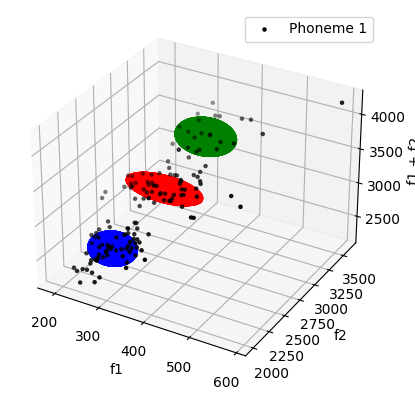

In [32]:
RUN_ME(covTransform=covTransform_1)

**METHOD 2**: Transform the training data (for training only) by taking the logarithm of the last column $F_1+F_2$...

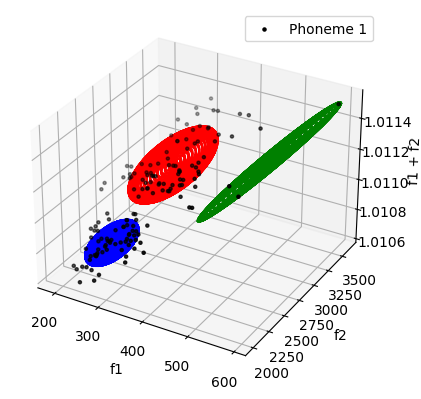

In [38]:
RUN_ME(covTransform=None, dataTransform=dataTransform_1)

**DISCUSSION**:

We observe that by converting the convariance matrix to a diagonal matrix (i.e. setting all covariance values to zero), we are able to train the model without encountering singularities, which is expected since the determinant of diagonal matrix with no zeros in the diagonal can never be zero. The mixture of Gaussians is able to cluster (with soft clustering) most of the points of the given data (thereby will be able to appropriately classify new observations), indicating that assuming zero covariance between the features was a suitable assumption to make in this context.

**SIDE NOTE**: _The diagonal elements are the variances of the features, and we expect there to be no zeros in the diagonal since the feature values are expected to have at least some variance._

We also observe that by transforming the third feature $F_1+F_2$ using cube root, we are able to remove the linear dependence between this feature and the features $F_1$ and $F_2$, resulting in a covariance matrix that does not reflect perfect correlation, and thus, whose determinant is never zero. The mixture of Gaussians is able to cluster (and thereby will be able to appropriately classify) most of the points of the given data. In most iterations of the training loop, we can observe that using this transformation of the last column can lead to the multivariate Gaussians in the mixture to containing higher covariance values between certain features (which is expected, since $F_1$ and $F_2$ are closely related to $F_1+F_2$ and hence to $(F_1+F_2)^{\frac{1}{3}})$, leading to more tightly-fitting clusters that tend to include more distant points. This indicates that in general, transforming the training data may lead to more accurate models that better reflect the relationship between features.